In [1]:
from PIL import Image
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle, PathPatch, Circle
from matplotlib.image import AxesImage
from matplotlib.transforms import Affine2D
from matplotlib.lines import Line2D
from matplotlib.figure import Figure
import numpy as np
import pandas as pd

import matplotliblayout as layout
import svg2matplotlib as svg

# Maplotlib Business Card

Creates a business card design using Matplotlib as an exercise in achieving pixel-perfect Matplotlib layouts.

## Utilities
These utilities are used by methods further down in the workflow.

In [2]:
def transform(from_box: Bbox, to_box: Bbox) -> Affine2D:
    """
    Given a source and target box, returns the transform that converts the source 
    bounding box into the target bounding box. The intended use case is for precise 
    positioning of svg assets.
    """
    scalex, scaley = to_box.width / from_box.width, to_box.height / from_box.height
    transx, transy = to_box.x0 - from_box.x0, to_box.y0 - from_box.y0
    return Affine2D().scale(scalex, scaley).translate(transx, transy)

def inches_to_figure_space(inches: Bbox, fig: Figure) -> Bbox:
    """
    Given a Bbox in inches, return a Bbox in figure fractions
    """
    width, height = fig.get_size_inches()
    return Bbox.from_bounds(
        inches.x0 / width, inches.y0 / height,
        inches.width / width, inches.height / height
    )

def pixels_to_figure_space(pixels: Bbox, fig: Figure) -> Bbox:
    """
    Given a Bbox in pixels, return a Bbox in figure fractions
    """
    return inches_to_figure_space(
        Bbox.from_bounds(*[x / fig.dpi for x in pixels.bounds]), fig
    )

def circle_from_box(box: Bbox, transform) -> Circle:
    return mpl.patches.Circle(
        (
            (box.x0 + box.x1) / 2,
            (box.y0 + box.y1) / 2
        ),
        box.height / 2,
        transform = transform
    )

def add_debug_box(
    box: Bbox, 
    fig: mpl.figure.Figure,
    facecolor = 'none', edgecolor = ('k', 0.5), linestyle = '--', linewidth = 1
):
    rect = Rectangle((box.x0, box.y0), box.width, box.height)
    rect.set_facecolor(facecolor)
    rect.set_edgecolor(edgecolor)
    rect.set_linewidth(linewidth)
    rect.set_linestyle(linestyle)
    fig.add_artist(rect)

def add_vline(
    fig,
    offset: float,
    start = 0, end = 1,
    **kwargs
):
    kwargs = kwargs or { 'linestyle': "--", 'color': ('k', 0.5 ), 'linewidth': 1 }
    line = Line2D((offset, offset), (start, end), **kwargs)
    fig.add_artist(line)

def add_hline(
    fig,
    offset: float,
    start = 0, end = 1,
    **kwargs
):
    line = Line2D((start, end), (offset, offset), **kwargs)
    fig.add_artist(line)


## Data
Define the data that will drive the business card:

In [3]:
# card data
def read_card_data(path = 'assets/card_data.json') -> dict:
    with open(path) as file:
        return json.load(file)
        
card_data = read_card_data()
contact_info = { key:card_data[key] for key in ['web', 'github', 'email', 'phone'] }

## Style

Define layout, fonts, and colors used in the design

In [4]:
# Prevents Jupyter Labs from adding unwanted margins to figures.
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

# Business card dimensions. Units are in inches.
card_width = 3.5
card_height = 2
margin_x, margin_y = 0.5, 0.125

bleed = 0.125 # amount of additional margin past the visible margin, which gets cut off while making cards. This is considered a best practice to avoid visual artifacts near the border.
points_per_inch = 72
dpi = 180 # matplotlib chart matches printed size on the device used for testing
dpi = 300 # optimal quality

# fonts, colors, and styles. Units are in points.
background_color = '0.95'
primary_color = 'C0'
title_style = { 'fontsize': 18, 'fontweight': 'bold', 'color': 'w' }
subtitle_style = { 'fontsize': 11, 'fontweight': 'bold', 'color': 'w' }
contact_label_style = { 'fontsize': 7 }
contact_field_style = { 'color': 'w', 'edgecolor': ('k', 0.5), 'linewidth': 0.5 }
contact_icon_size = 13
contact_icon_style = { 'edgecolor': 'none', 'linewidth': 0.5 }
contact_tick_color = contact_field_style['edgecolor']

########################
# Card content layout
# All units in inches unless specified otherwise.
########################
fig_width, fig_height = card_width + 2 * bleed, card_height + 2 * bleed
fig = plt.figure(figsize = (fig_width, fig_height), dpi = dpi)

# Headshot
headshot_size = 0.5
headshot_area = Bbox.from_bounds(
    bleed + margin_x, bleed + margin_y,
    headshot_size, headshot_size
) # In header space, with y origin at top
headshot_line_style = { 'color': 'k', 'linewidth': 1 }

# Header / title / subtitle
header_area = Bbox.from_extents(
    0, fig_height - bleed - headshot_size - 2 * margin_y,
    fig_width, fig_height
)

title_subtitle_spacing = 2 # pt
title_subtitle_height = (title_style['fontsize'] + subtitle_style['fontsize'] + title_subtitle_spacing) / points_per_inch
title_subtitle_top = headshot_area.y0 + (headshot_size - title_subtitle_height) / 2 # Center vertical align the title + subtitle with the headshot
title_subtitle_area = Bbox.from_extents(
    headshot_area.x1 + margin_y, title_subtitle_top,
    fig_width - bleed - margin_x, title_subtitle_top + title_subtitle_height
)
print('TITLE+SUBTITLE', title_subtitle_area)

contact_boxes_area = Bbox.from_extents(
    title_subtitle_area.x0, bleed + 2 * margin_y,
    title_subtitle_area.x1, header_area.y0 - margin_y
) # Area of group of bars/boxes surrounding contact info
contact_boxes_intrinsic_margin_y = 3 / 72 # Additional implicit margin between contact area top/bottom bars and borders. Used for precise alignment of contents.
contact_icon_margin_x = margin_y * dpi
contact_field_margin_x = margin_y * points_per_inch
print(contact_icon_margin_x, contact_field_margin_x)

footer_style = { 'fontsize': 5, 'color': ('k', 0.5) }
footer_height = footer_style['fontsize'] / points_per_inch
footer_spacing = 0
footer_area = inches_to_figure_space(Bbox.from_bounds(
    bleed + margin_x, bleed + margin_y - footer_spacing - footer_height,
    card_width, footer_height
), fig)

cut_tick_style = { 'color': 'r', 'linewidth': 1 }
cut_tick_length = 5 / 72

# portrait orientation variation:
portrait_orientation = False
if portrait_orientation:
    card_width = 2
    card_height = 3.5
    margin_x, margin_y = 0.125, 0.25
    header_height_relative = 1/5

TITLE+SUBTITLE Bbox(x0=1.25, y0=0.2847222222222222, x1=3.125, y1=0.7152777777777778)
37.5 9.0


<Figure size 1125x675 with 0 Axes>

## Create Card

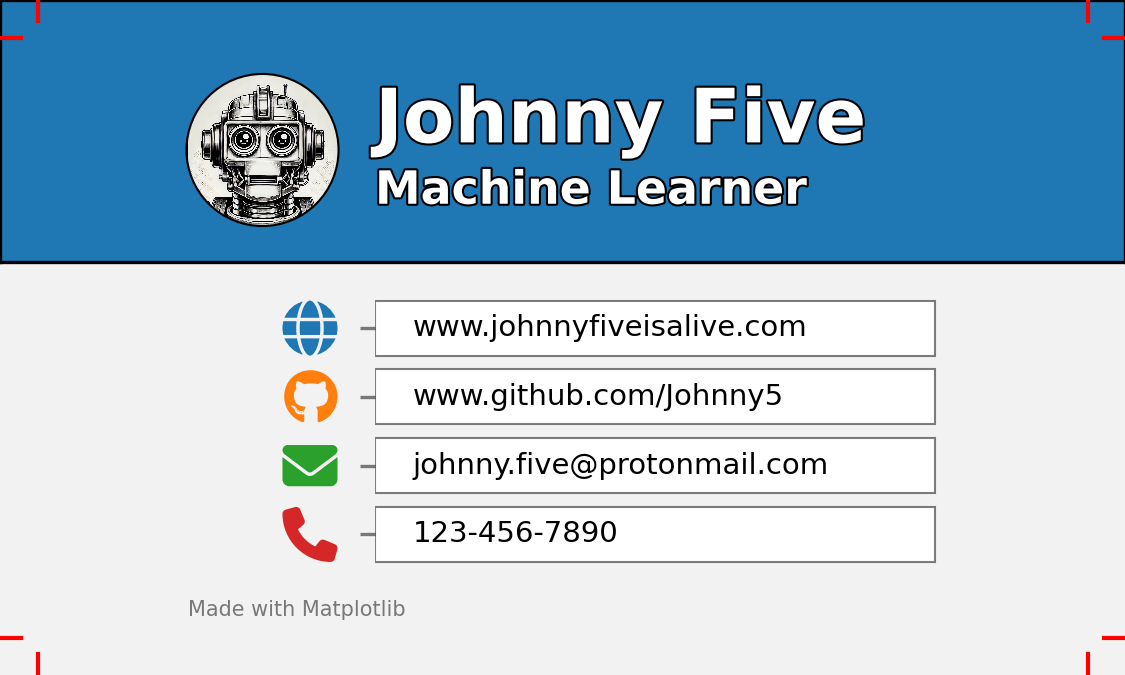

In [5]:
def add_cut_marks(fig: Figure, bleed = 0.125):
    fig_width, fig_height = fig.get_size_inches()
    bleed_width, bleed_height = bleed / fig_width, bleed / fig_height
    tick_width, tick_height = cut_tick_length / fig_width, cut_tick_length / fig_height
    for offset in (bleed_height, 1 - bleed_height):
        add_hline(fig, offset, end = tick_width, **cut_tick_style)
        add_hline(fig, offset, start = 1 - tick_width, **cut_tick_style)     
    for offset in (bleed_width, 1 - bleed_width):
        add_vline(fig, offset, end = tick_height, **cut_tick_style)
        add_vline(fig, offset, start = 1 - tick_height, **cut_tick_style)  

#################
# Card Creation
#################
def plot_business_card(card_data: dict, fig = None):
    # Figure
    if fig is None:
        fig_width, fig_height = card_width + 2 * bleed, card_height + 2 * bleed
        fig = plt.figure(figsize = (fig_width, fig_height), dpi = dpi)
    fig.set_facecolor(background_color)

    ############
    # Header
    ############
    header = fig.add_axes(inches_to_figure_space(header_area, fig))
    header.set(
        facecolor = primary_color,
        # Let's set up a header data space in print-centric format, with units in inches and y axis originating at the top:
        xlim = (0, fig_width), # data units are inches
        ylim = (header_area.height, 0), # inverted order to flip y axis
    )
    header.xaxis.set_visible(False)
    header.yaxis.set_visible(False)

    # Image
    img = Image.open('assets/headshot.jpg')
    im = AxesImage(header, origin = 'lower')
    im.set_data(img)
    box = headshot_area    
    im.set_extent((box.x0, box.x1, box.y0, box.y1))
    circle = circle_from_box(box, header.transData)
    im.set_clip_path(circle)
    header.add_image(im)    
    # image outline
    outline = circle_from_box(box, header.transData)
    outline.set_zorder(im.get_zorder() - 1)
    outline.set(**headshot_line_style)
    header.add_artist(outline)

    # Title
    x, y = title_subtitle_area.x0, title_subtitle_area.y0
    title = header.annotate(
        card_data['name'],
        xy = (x, y), verticalalignment = 'top', horizontalalignment = 'left',
        **title_style
    )
    # Subtitle
    y += (title_style['fontsize']  + title_subtitle_spacing) / points_per_inch
    subtitle = header.annotate(
        card_data['subtitle'],
        xy = (x, y), verticalalignment = 'top', horizontalalignment = 'left',
        **subtitle_style
    )
    layout.add_outline(title)
    layout.add_outline(subtitle)


    ##########
    # Contact
    ##########
        
    # Layout
    contact = fig.add_axes(inches_to_figure_space(Bbox.from_bounds(
            contact_boxes_area.x0, contact_boxes_area.y0 - contact_boxes_intrinsic_margin_y,
            contact_boxes_area.width, contact_boxes_area.height + 2 * contact_boxes_intrinsic_margin_y
        )
    , fig), frameon = False)
    ys = list(reversed(range(len(contact_info)))) # reverse y order so that fields appear top to bottom (screen space) instead of bottom to top
    contact.set(
        xlim = (0, 1), xticks = [],
        yticks = ys, yticklabels = [' '] * len(ys),
        clip_on = False
    )

    # Boxes
    bars = plt.barh(
        ys, 
        width = 0.995, # marginally less than 1 to prevent right border from being clipped
        **contact_field_style
    )


    fig.canvas.draw() # Force bar rects to update
    for index, (key, value, box, label) in enumerate(zip(contact_info.keys(), contact_info.values(), bars, contact.get_yticklabels())):
        # Contact info labels
        contact.annotate(
            value, 
            xy = (box.get_x(), box.get_center()[1]), verticalalignment = 'center', horizontalalignment = 'left',
            xytext = (contact_field_margin_x, 0), textcoords = 'offset points',
            **contact_label_style
        )

        # Icons
        # Matplotlib does not have built-in capabilities for icons as tick labels, so we (very tediously) insert the icons manually.
        # A vector font library is theoretically a much easier alternative, but free vector font libraries generally lack commercial symbols like github.
        # Also, learning how to use svg in matplotlib is generally useful.

        # 2. Calculate icon location
        box_px = box.get_window_extent()
        asset_file = f'assets/{key}.svg'
        path, properties = svg.read_svg(asset_file, height = box_px.height)
        icon_width, icon_height = properties['size']
        icon_right_px = box_px.x0 - contact_icon_margin_x

        bbox_asset = Bbox.from_bounds(0,0, icon_width, icon_height) # Asset size pixels
        bbox_icon = pixels_to_figure_space(Bbox.from_bounds(
            icon_right_px - icon_width, box_px.y0, icon_width, icon_height
        ), fig) # Desired asset location in figure-relative space

        # 2. place icon in bounding box.
        # Do this by applying a transform (translation + scale) to the original SVG path
        patch = PathPatch(path, facecolor = f'C{index}', **contact_icon_style)
        #from_bbox = Bbox.from_bounds(0, 0, box_px.width, icon_box_px.height)
        patch.set_transform(transform(bbox_asset, bbox_icon) + fig.transFigure)
        fig.add_artist(patch)
    
    # Tick color
    contact.yaxis.set_tick_params(color = contact_tick_color)

    #########
    # Footer
    #########
    footer = fig.add_axes(footer_area, frameon = False)
    footer.xaxis.set_visible(False)
    footer.yaxis.set_visible(False)
    txt = footer.annotate(
        'Made with Matplotlib', 
        (0,0.5), horizontalalignment = 'left', verticalalignment = 'center', 
        **footer_style
    )

    ############
    # Cut Marks
    ############
    # bleed_width, bleed_height = bleed / fig_width, bleed / fig_height
    # tick_width, tick_height = cut_tick_length / fig_width, cut_tick_length / fig_height
    # for offset in (bleed_height, 1 - bleed_height):
    #     add_hline(fig, offset, end = tick_width, **cut_tick_style)
    #     add_hline(fig, offset, start = 1 - tick_width, **cut_tick_style)     
    # for offset in (bleed_width, 1 - bleed_width):
    #     add_vline(fig, offset, end = tick_height, **cut_tick_style)
    #     add_vline(fig, offset, start = 1 - tick_height, **cut_tick_style)     
    add_cut_marks(fig)   

plot_business_card(card_data)
plt.savefig(f'output/BusinessCard-{dpi}dpi.png')

## Debug

Show layout details of the card to validate alignments:
- Title text at top left of content area
- Contact info contents extending to bottom, left, and right edges of content area
- Contact info icons left aligned with title/subtitle
- Equal vertical spacing for 'Made with Matplotlib' and contact area top

1. Figure(xy = (0, 0), width = 1125, height = 675)
| 1. Rectangle(xy = (0, 0), width = 1125, height = 675)
| 2. PathPatch(xy = (282, 319), width = 55, height = 55)
| 3. PathPatch(xy = (284, 253), width = 53, height = 52)
| 4. PathPatch(xy = (282, 189), width = 55, height = 41)
| 5. PathPatch(xy = (282, 113), width = 55, height = 55)
| 6. Line2D(xy = (0, 38), width = 21, height = 0)
| 7. Line2D(xy = (1104, 38), width = 21, height = 0)
| 8. Line2D(xy = (0, 638), width = 21, height = 0)
| 9. Line2D(xy = (1104, 638), width = 21, height = 0)
| 10. Line2D(xy = (38, 0), width = 0, height = 21)
| 11. Line2D(xy = (38, 654), width = 0, height = 21)
| 12. Line2D(xy = (1088, 0), width = 0, height = 21)
| 13. Line2D(xy = (1088, 654), width = 0, height = 21)
| 14. Rectangle(xy = (38, 38), width = 1050, height = 600)
| 15. Rectangle(xy = (188, 75), width = 750, height = 525)
| 16. Axes(xy = (0, 413), width = 1125, height = 262)
| | 1. AxesImage(xy = (188, 600), width = 150, height = -150)
| | 2. Circ

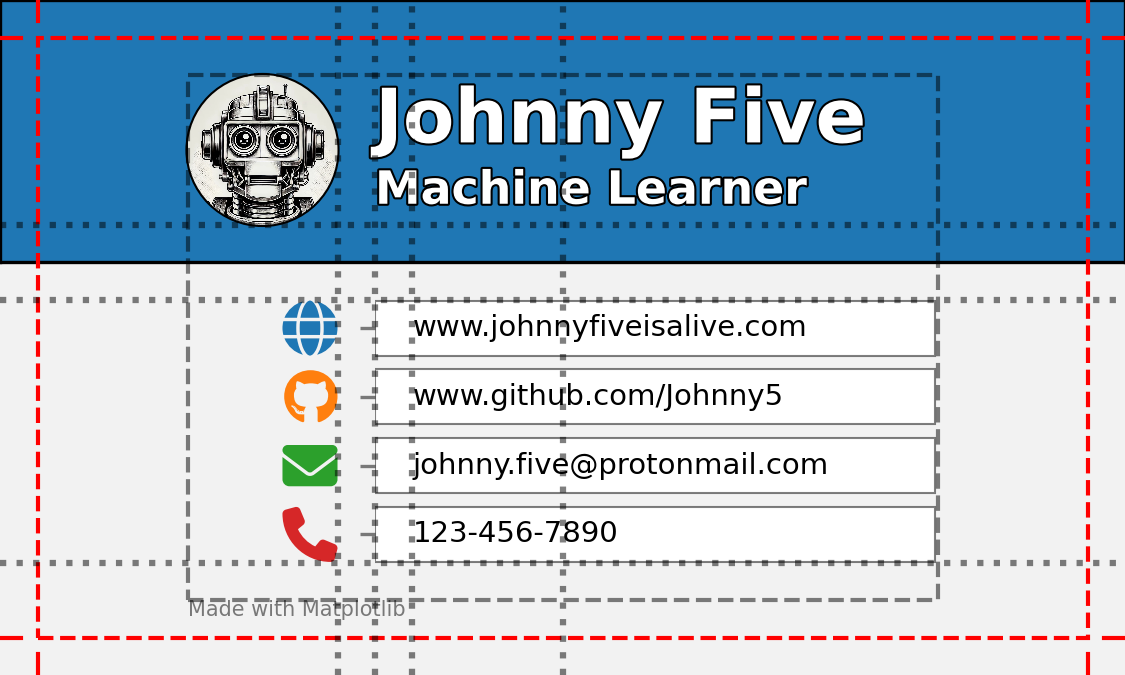

In [6]:
plot_business_card(card_data)
fig = plt.gcf()
fig_width, fig_height = fig.get_size_inches()

# show bleed
bleed_rect = Bbox.from_extents(
    bleed / fig_width, bleed / fig_height,
    1 - bleed / fig_width, 1 - bleed / fig_height
)
add_debug_box(bleed_rect, fig, edgecolor = 'r')
# show content area
content_rect = Bbox.from_bounds(
    (bleed + margin_x) / fig_width, (bleed + margin_y) / fig_height,
    (card_width- 2 * margin_x) / fig_width, (card_height - 2 * margin_y) / fig_height
)
add_debug_box(content_rect, fig)

# Debug-log entire hierarchy
layout.print_layout(fig)

# Show alignments
line_style = { 'linestyle': ':', 'color': ('k', 0.5)}
add_vline(fig, 0.5, **line_style)
add_vline(fig, headshot_area.x1 / fig_width, **line_style)
add_vline(fig, title_subtitle_area.x0 / fig_width, **line_style)
add_vline(fig, (title_subtitle_area.x0 + margin_y) / fig_width, **line_style)
add_hline(fig, (header_area.y0 - margin_y) / fig_height, **line_style)
add_hline(fig, (header_area.y0 + margin_y) / fig_height, **line_style)
add_hline(fig, (bleed + 2 * margin_y) / fig_height, **line_style)

plt.savefig('output/BusinessCard-annotated.png')


## Backside

On the reverse side of the card, show a list of out attributes and percentile ranges according to ChatGPT, based on ChatGPT history:

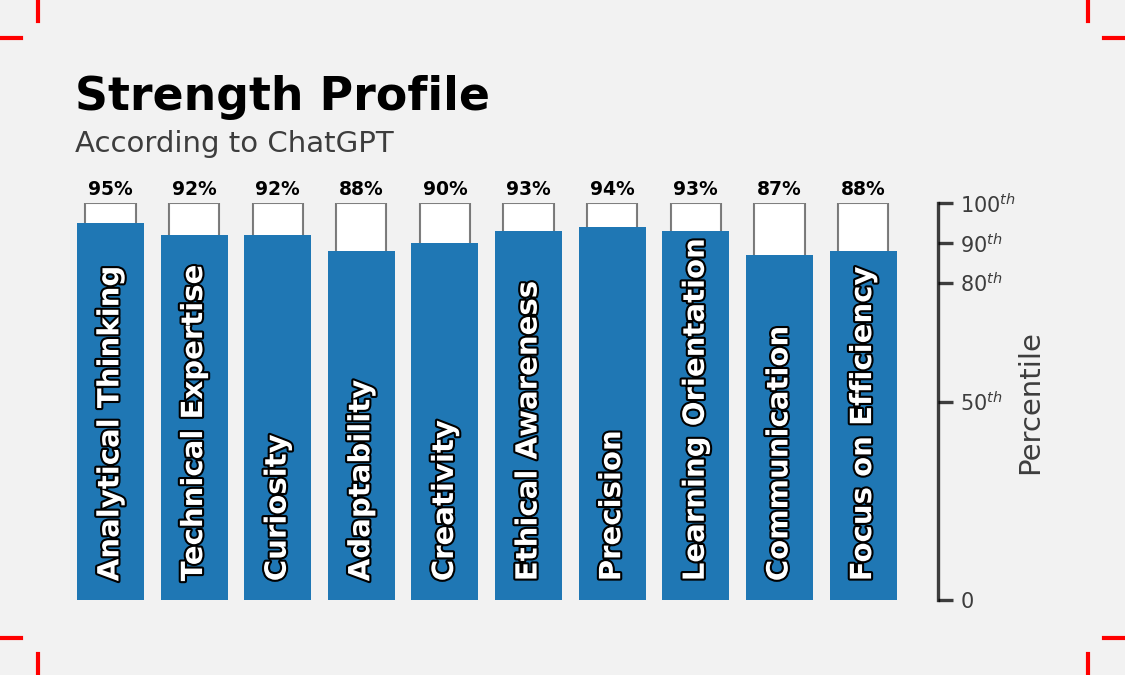

In [7]:
# Data
from streamlit import area_chart


def load_data(path = 'assets/evaluation_data.csv') -> pd.DataFrame:
    return pd.read_csv(path)
    
percentiles = load_data()

# Style
r_title_style = { 'fontsize': 11, 'fontweight': 'bold' }
r_subtitle_style = { 'fontsize': 7, 'color': ('k', 0.75) }
r_bar_style = { 'color': 'C0', 'edgecolor': 'k' }
bar_label_style = { 'fontsize': 7, 'fontweight': 'bold', 'color': 'w' }
bar_percentage_style = { 'fontsize': 4.5, 'fontweight': 'bold' }
axis_label_style = { 'fontsize': 7, 'color': ('k', 0.75), 'labelpad': 0 }
tick_label_style = { 'labelrotation': 0, 'labelsize': 5, 'pad': 2, 'color': ('k', 0.75), 'labelcolor': ('k', 0.75) }

# Layout
r_width, r_height = 3.5, 2
r_margin_x, r_margin_y = 0.125, 0.125
r_fig_width, r_fig_height = r_width + 2 * bleed, r_height + 2 * bleed

bar_label_offset = r_margin_y / 2 * points_per_inch
bar_percentage_label_offset = 1
r_title_subtitle_height = (r_title_style['fontsize'] + r_subtitle_style['fontsize'] + title_subtitle_spacing) / points_per_inch

mid_x = fig_width / 2
attributes_area = Bbox.from_extents(
    bleed + r_margin_x, bleed + r_margin_y,
    fig_width - bleed - r_margin_x, fig_height - bleed - r_title_subtitle_height - r_margin_y
)
attributes_internal_margins = Bbox.from_extents(
    -0.13,
    0,
    0.375, # pop rightmost bar out to right-align with the edge of the chart. I.e. remove the intrinsic right margin.
    0.15    # leave room for labels on top of the bars
)
#attributes_internal_margins = Bbox.from_extents(0,0,0,0)

# Figure
def create_card_reverse():
    r_fig = plt.figure(figsize = (r_fig_width, r_fig_height), dpi = dpi)
    r_fig.set_facecolor(background_color)

    chart = r_fig.add_axes(inches_to_figure_space(Bbox.from_extents(
        attributes_area.x0 + attributes_internal_margins.x0, attributes_area.y0 + attributes_internal_margins.y0,
        attributes_area.x1 - attributes_internal_margins.x1, attributes_area.y1 - attributes_internal_margins.y1
    ), r_fig), ylim = (0,100))

    ticks = [0, 50, 80, 90, 100]
    labels = ['0', '$50^{th}$', '$80^{th}$', '$90^{th}$', '$100^{th}$']
    chart.set(
        facecolor = 'none',
        yticks = ticks, yticklabels = labels,
        xticks = []
    )
    chart.spines[:].set_visible(False)
    chart.spines['right'].set_visible(True)
    chart.spines['right'].set_color(tick_label_style['color'])
    chart.yaxis.set_label_position('right')
    chart.yaxis.set_ticks_position('right')
    chart.set_ylabel('Percentile', **axis_label_style)
    chart.yaxis.set_tick_params(**tick_label_style)

    # for index, strength in percentiles.iterrows():
    #     print(index, strength)
    #     ax = chart
    #     title, percentile = strength.title, strength.percentile
    #     bar = ax.barh(row, 1, color = 'C1')
    bars_backgrounds = chart.bar(percentiles['title'], 100, width = 0.6, **contact_field_style)
    bars = chart.bar(percentiles['title'], percentiles['percentile'])
    for bar, title, percentile in zip(bars, percentiles.title, percentiles.percentile):
        text = chart.annotate(
            title,
            xy = (bar.get_center()[0], bar.get_y()), ha = 'center', va = 'bottom',
            xytext = (0, bar_label_offset), textcoords = 'offset points',
            rotation = 90,
            **bar_label_style
        )
        layout.add_outline(text)

        chart.annotate(
            f'{percentile}%',
            xy = (bar.get_center()[0], 100), va = 'bottom', ha = 'center',
            xytext = (0, bar_percentage_label_offset), textcoords = 'offset points',
            **bar_percentage_style
        )

    
    plt.suptitle("Strength Profile", ha = 'left', x = (bleed + r_margin_x) / fig_width, y = 1 - (bleed + margin_y) / fig_height, **r_title_style)
    plt.annotate(
        'According to ChatGPT',
        xy = (attributes_area.x0 * points_per_inch, attributes_area.y1 * points_per_inch), xycoords = 'figure points', ha = 'left', va = 'bottom',
        **r_subtitle_style
    )

    add_cut_marks(r_fig)

create_card_reverse()
# # show bleed
# fig = plt.gcf()
# add_debug_box(bleed_rect, fig, edgecolor = 'r')
# # show content area
# r_content_rect = Bbox.from_bounds(
#     (bleed + r_margin_x) / fig_width, (bleed + r_margin_y) / fig_height,
#     (card_width - 2 * r_margin_x) / fig_width, (card_height - 2 * r_margin_y) / fig_height
# )
# add_debug_box(r_content_rect, fig)
# add_debug_box(inches_to_figure_space(attributes_area, fig), fig)
# add_vline(fig, 0.5)

plt.savefig(f'output/BusinessCard-{dpi}dpi-back.png')

## PNG / Headshot

Let's mock up how to load and lay out raster/png graphics in Matplotlib. Matplotlib does not support displaying assets directly. However, we can use PIL to load image data and low-level matplotlib APIs (AxesImage, clip_path, transforms) to display the image data as needed.

Displaying an avatar image is relatively straightforward:

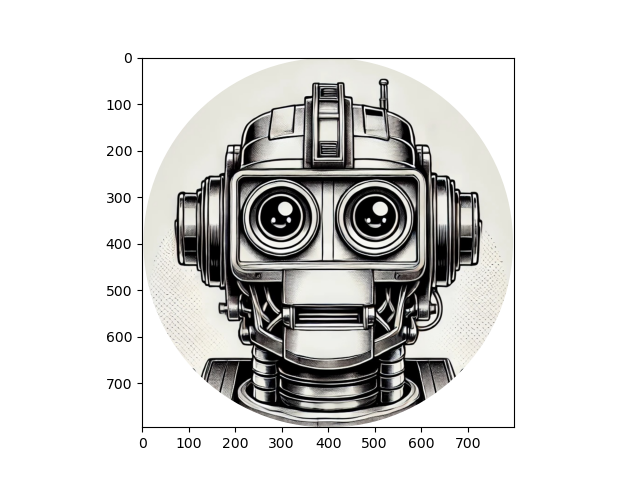

In [8]:
from PIL import Image
import PIL

image = Image.open('assets/headshot.jpg')
width, height = image.size
ax = plt.gca()
fig = ax.figure
im = plt.imshow(image)
circle = mpl.patches.Circle((width/2,height/2), radius = height/2, transform = ax.transData)
im.set_clip_path(circle)

Laying out the image is more difficult, requiring acces to low-level APIs. The imshow method leverages **AxesImage** under the hood, which we can use directly to place the image into an existing canvas/plot instead of the image taking ownership of the plot and altering its coordinate system:

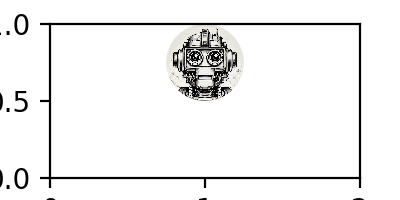

In [9]:
image = Image.open('assets/headshot.jpg')
image_width, image_height = image.size

width, height = 2,1
fig = plt.figure(figsize = (width, height), dpi = 200)
image_size_in = 0.5

ax = plt.gca()

ax.set_xlim(0, width)
ax.set_ylim(0, height)

im = mpl.image.AxesImage(ax) # use AxesImage directly instead of imshow to prevent imshow from making unwanted alterations to the figure.
im.set_data(image)
box = Bbox.from_bounds(0.75, 0.5, image_size_in, image_size_in)
im.set_extent((box.x0, box.x1, box.y0, box.y1)) # This is the key change, and positions the image within a region instead of having it take up the entirety of a chart.
circle = circle_from_box(box, transform = ax.transData) # Add rounded effect
im.set_clip_path(circle)
ax.add_image(im)

Now let's put it all together by mocking up a representative layout that aligns images and text:

1. Figure(xy = (0, 0), width = 700, height = 400)
| 1. Rectangle(xy = (0, 0), width = 700, height = 400)
| 2. Axes(xy = (0, 0), width = 700, height = 400)
| | 1. Rectangle(xy = (50, 233), width = 117, height = 117)
| | 2. Annotation:'Title'(xy = (194, 283), width = 149, height = 67)
| | 3. Annotation:'Subtitle'(xy = (194, 227), width = 161, height = 40)
| | 4. AxesImage(xy = (50, 233), width = 117, height = 117)
| | 5. Circle(xy = (50, 233), width = 117, height = 117)
| | 6. Spine(xy = (-10, 0), width = 10, height = 400)
| | 7. Spine(xy = (700, 0), width = 0, height = 400)
| | 8. Spine(xy = (0, -10), width = 700, height = 10)
| | 9. Spine(xy = (0, 400), width = 700, height = 0)
| | 10. XAxis(xy = (0, 0), width = 0, height = 0)
| | | 1. Text:''(xy = (350, 0), width = 0, height = 0)
| | | 2. Text:''(xy = (700, 0), width = 0, height = 0)
| | | 3. XTick(xy = (0, 0), width = 0, height = 0)
| | | | 1. Line2D(xy = (-5, -5), width = 10, height = 10)
| | | | 2. Line2D(xy = (-5, 395), width = 10

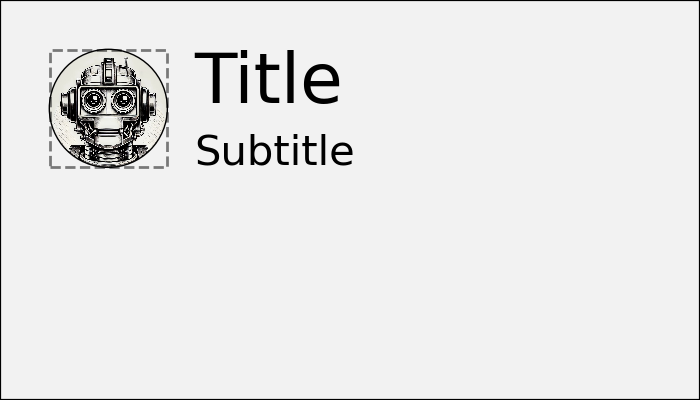

In [10]:
width = 3.5
height = 2
margin = 0.25
title_size = 25
subtitle_size = 15
subtitle_spacing = 5
image_spacing = 10
title_subtitle_height = (title_size + subtitle_size + title_subtitle_spacing) / 72
image_width = image_height = title_subtitle_height

fig = plt.figure(figsize = (width, height), dpi = 200)
fig.set_facecolor('r')
ax = fig.add_axes((0,0,1,1))
ax.set(
     xlim = (0, width),
     ylim = (0, height)
)
ax.set_facecolor('0.95')

avatar_area = Bbox.from_bounds(
    margin,
    height - margin - image_height,
    image_width, image_height
)
rect = Rectangle(avatar_area.p0, avatar_area.width, avatar_area.height)
rect.set(
    facecolor = 'none', edgecolor = ('k', 0.5), linestyle = '--', linewidth = 1
)
ax.add_artist(rect)

x = margin + image_width + image_spacing / 72
y = height - margin
ax.annotate('Title', (x, y), fontsize = title_size, verticalalignment = 'top')
y = y - title_size/72 - subtitle_spacing/72
ax.annotate('Subtitle', (x, y), fontsize = subtitle_size, verticalalignment = 'top')

image = Image.open('assets/headshot.jpg')
aximage = mpl.image.AxesImage(ax)
aximage.set_data(image)
# Specify the area for the image to take up, in data coordinates = inches
aximage.set_extent([avatar_area.x0, avatar_area.x1, avatar_area.y0, avatar_area.y1])
circle = circle_from_box(avatar_area, ax.transData)
aximage.set_clip_path(circle)
ax.add_image(aximage)

outline = circle_from_box(avatar_area, ax.transData)
outline.set(
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1
)
outline.set_zorder(aximage.get_zorder() - 1)
ax.add_artist(outline)

#print('AXIMG.TRANS', aximage.get_transform())
layout.print_layout(fig)


## SVG

Loading SVG graphics is a significant challenge. The following example from the matplotlib showcase website demonstrates a bare-bones SVG reader:

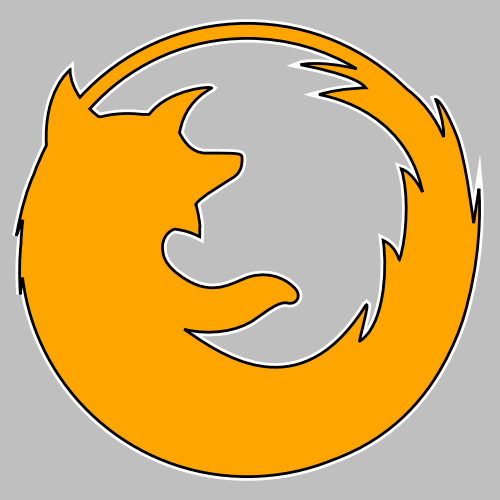

In [11]:
# From matplotlib showcase: https://matplotlib.org/stable/gallery/showcase/firefox.html

import re

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as patches
from matplotlib.path import Path

# From: https://dmitrybaranovskiy.github.io/raphael/icons/#firefox
firefox = "M28.4,22.469c0.479-0.964,0.851-1.991,1.095-3.066c0.953-3.661,0.666-6.854,0.666-6.854l-0.327,2.104c0,0-0.469-3.896-1.044-5.353c-0.881-2.231-1.273-2.214-1.274-2.21c0.542,1.379,0.494,2.169,0.483,2.288c-0.01-0.016-0.019-0.032-0.027-0.047c-0.131-0.324-0.797-1.819-2.225-2.878c-2.502-2.481-5.943-4.014-9.745-4.015c-4.056,0-7.705,1.745-10.238,4.525C5.444,6.5,5.183,5.938,5.159,5.317c0,0-0.002,0.002-0.006,0.005c0-0.011-0.003-0.021-0.003-0.031c0,0-1.61,1.247-1.436,4.612c-0.299,0.574-0.56,1.172-0.777,1.791c-0.375,0.817-0.75,2.004-1.059,3.746c0,0,0.133-0.422,0.399-0.988c-0.064,0.482-0.103,0.971-0.116,1.467c-0.09,0.845-0.118,1.865-0.039,3.088c0,0,0.032-0.406,0.136-1.021c0.834,6.854,6.667,12.165,13.743,12.165l0,0c1.86,0,3.636-0.37,5.256-1.036C24.938,27.771,27.116,25.196,28.4,22.469zM16.002,3.356c2.446,0,4.73,0.68,6.68,1.86c-2.274-0.528-3.433-0.261-3.423-0.248c0.013,0.015,3.384,0.589,3.981,1.411c0,0-1.431,0-2.856,0.41c-0.065,0.019,5.242,0.663,6.327,5.966c0,0-0.582-1.213-1.301-1.42c0.473,1.439,0.351,4.17-0.1,5.528c-0.058,0.174-0.118-0.755-1.004-1.155c0.284,2.037-0.018,5.268-1.432,6.158c-0.109,0.07,0.887-3.189,0.201-1.93c-4.093,6.276-8.959,2.539-10.934,1.208c1.585,0.388,3.267,0.108,4.242-0.559c0.982-0.672,1.564-1.162,2.087-1.047c0.522,0.117,0.87-0.407,0.464-0.872c-0.405-0.466-1.392-1.105-2.725-0.757c-0.94,0.247-2.107,1.287-3.886,0.233c-1.518-0.899-1.507-1.63-1.507-2.095c0-0.366,0.257-0.88,0.734-1.028c0.58,0.062,1.044,0.214,1.537,0.466c0.005-0.135,0.006-0.315-0.001-0.519c0.039-0.077,0.015-0.311-0.047-0.596c-0.036-0.287-0.097-0.582-0.19-0.851c0.01-0.002,0.017-0.007,0.021-0.021c0.076-0.344,2.147-1.544,2.299-1.659c0.153-0.114,0.55-0.378,0.506-1.183c-0.015-0.265-0.058-0.294-2.232-0.286c-0.917,0.003-1.425-0.894-1.589-1.245c0.222-1.231,0.863-2.11,1.919-2.704c0.02-0.011,0.015-0.021-0.008-0.027c0.219-0.127-2.524-0.006-3.76,1.604C9.674,8.045,9.219,7.95,8.71,7.95c-0.638,0-1.139,0.07-1.603,0.187c-0.05,0.013-0.122,0.011-0.208-0.001C6.769,8.04,6.575,7.88,6.365,7.672c0.161-0.18,0.324-0.356,0.495-0.526C9.201,4.804,12.43,3.357,16.002,3.356z"  # noqa


def svg_parse(path):
    commands = {'M': (Path.MOVETO,),
                'L': (Path.LINETO,),
                'Q': (Path.CURVE3,)*2,
                'C': (Path.CURVE4,)*3,
                'Z': (Path.CLOSEPOLY,)}
    vertices = []
    codes = []
    cmd_values = re.split("([A-Za-z])", path)[1:]  # Split over commands.
    for cmd, values in zip(cmd_values[::2], cmd_values[1::2]):
        # Numbers are separated either by commas, or by +/- signs (but not at
        # the beginning of the string).
        points = ([*map(float, re.split(",|(?<!^)(?=[+-])", values))] if values
                  else [(0., 0.)])  # Only for "z/Z" (CLOSEPOLY).
        points = np.reshape(points, (-1, 2))
        if cmd.islower():
            points += vertices[-1][-1]
        codes.extend(commands[cmd.upper()])
        vertices.append(points)
    return np.array(codes), np.concatenate(vertices)


# SVG to Matplotlib
codes, verts = svg_parse(firefox)
path = Path(verts, codes)

xmin, ymin = verts.min(axis=0) - 1
xmax, ymax = verts.max(axis=0) + 1

fig = plt.figure(figsize=(5, 5), facecolor="0.75")  # gray background
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1,
                  xlim=(xmin, xmax),  # centering
                  ylim=(ymax, ymin),  # centering, upside down
                  xticks=[], yticks=[])  # no ticks

# White outline (width = 6)
ax.add_patch(patches.PathPatch(path, facecolor='none', edgecolor='w', lw=6))
# Actual shape with black outline
ax.add_patch(patches.PathPatch(path, facecolor='orange', edgecolor='k', lw=2))

Unfortunately, the above demo implements only enough parsing capabilities to handle the Firefox logo. Both its point/vertex parsing and its support for svg path commands break down when using other icons. A full-featured svg parser is a substantial effort well beyond the scope of matplotlib's simple demo.

Let's build our own svg to matplotlib workflow, but also leverage an existing full-featured svg parser:

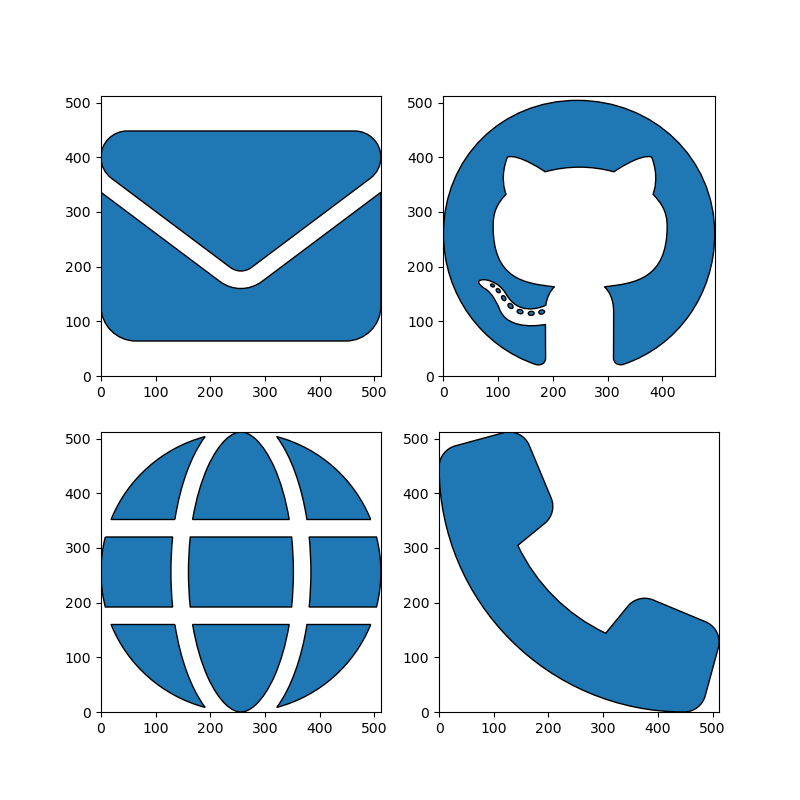

In [12]:
import svg2matplotlib as svg

fig = plt.figure(figsize = (8,8))
for index, img in enumerate(['email.svg', 'github.svg', 'web.svg', 'phone.svg']):
    plt.subplot(2, 2, index + 1)
    path, metadata = svg.read_svg('assets/' + img)
    x0, y0, x1, y1 = metadata['viewBox']
    patch = PathPatch(path)
    ax = plt.gca()
    ax.add_artist(patch)
    ax.set(
        xlim = (x0, x1),
        ylim = (y0, y1),
        aspect = 1
    )

### SVG Layout

Next, let's mock up how to lay out svg icons precisely as tick labels in a bar chart. This gets unexpectedly difficult:

web: Bbox(x0=75.0, y0=9.090909090909093, x1=325.0, y1=47.36842105263158)
web icon: 38.27751196172249 x 38.27751196172249 px
github: Bbox(x0=75.0, y0=56.9377990430622, x1=325.0, y1=95.21531100478468)
github icon: 37.081339712918655 x 38.27751196172248 px
email: Bbox(x0=75.0, y0=104.78468899521532, x1=325.0, y1=143.0622009569378)
email icon: 38.27751196172248 x 38.27751196172248 px
phone: Bbox(x0=75.0, y0=152.6315789473684, x1=325.0, y1=190.9090909090909)
phone icon: 38.277511961722496 x 38.277511961722496 px


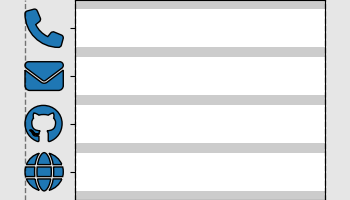

In [13]:
width, height = 3.5, 2
margin_x = 0.25
margin_icons = 0.5
margin_text = 0.125

fig = plt.figure(figsize = (width, height), dpi = 100) # using 100 dpi for easier debugging
fig.set_facecolor('0.9')
fig_margin_l, fig_margin_r = (margin_x + margin_icons) / width, margin_x / width
bar_width = width - 2 * margin_x - margin_icons
ax = fig.add_axes(
    (fig_margin_l, 0, bar_width / width, 1),
    xticks = [],
)
contact_fields = list(contact_info.keys())
bars = ax.barh(
    y = contact_fields,
    width = 1,
    color = 'w'
)
ax.set(
    facecolor = '0.8',
    yticks = range(len(contact_info)), yticklabels = ['    '] * len(contact_info),
    xlim = (0,1)
)

fig.canvas.draw() # force bar bounding box coordinates to update
for index, (bar, key) in enumerate(zip(bars, contact_fields)):
    bar_bounds = Bbox.from_extents(ax.transData.transform(bar.get_bbox())) # in pixels
    print(f'{key}: {bar_bounds}')
    asset_file = f'assets/{key}.svg'
    height_px = bar_bounds.height
    path, properties = svg.read_svg(asset_file, height = bar_bounds.height)
    icon_width, icon_height = properties['size']
    print(f'{key} icon: {icon_width} x {icon_height} px')    

    patch = PathPatch(path)
    # To lay out the svg onto the figure correctly:
    # 1. Convert from pixel space to figure-relative space (figure.add_artist only supports figure-relative space)
    # 2. Use a transform to move + scale the svg to the proper size + position (PathPatch does not support bounding boxes)
    bbox_asset = Bbox.from_bounds(0, 0, icon_width, icon_height)
    bbox_fig = pixels_to_figure_space(Bbox.from_bounds(
        margin_x * fig.dpi,
        bar_bounds.y0,
        icon_width, icon_height
    ), fig)
    patch.set_transform(transform(bbox_asset, bbox_fig) + fig.transFigure)
    fig.add_artist(patch)


add_vline(fig, margin_x / width)
add_vline(fig, (margin_x + margin_icons) / width)
add_vline(fig, (width - margin_x) / width)